<a href="https://colab.research.google.com/github/TheKreator666/Ekpa-ai-cyber-security-course/blob/main/IDS_IPS_DarkNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# ========================
# Υβριδικό IPS με εισαγωγή/εξαγωγή μοντέλων από GitHub + thresholds ανά κλάση + καταγραφή
# ========================
import os
import csv
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split   # Διαχωρισμός δεδομένων σε train/test/validation
from sklearn.preprocessing import StandardScaler       # Κλιμάκωση/κανονικοποίηση χαρακτηριστικών
from sklearn.utils.class_weight import compute_class_weight  # Υπολογισμός βαρών ανά κλάση για ανισοκατανομή
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score  # Μέτρηση απόδοσης μοντέλου

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model   # Δημιουργία και φόρτωση νευρωνικών δικτύων
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Conv1D, Flatten, LSTM  # Στρώματα δικτύων
from tensorflow.keras.optimizers import Adam                  # Βελτιστοποιητής Adam
from tensorflow.keras.callbacks import EarlyStopping          # Callback για πρόωρη διακοπή εκπαίδευσης
from tensorflow.keras.utils import to_categorical             # Μετατροπή ετικετών σε one-hot encoding


In [20]:
# ------------------------
# Αναπαραγωγιμότητα - Reproducibility
# ------------------------
# Ορισμός τυχαίων seeds για αναπαραγωγιμότητα. Διασφαλίζει ότι τα αποτελέσματα
# (όπως οι διαχωρισμοί train/test και η αρχικοποίηση των βαρών των μοντέλων)
# θα είναι ίδια σε κάθε εκτέλεση.
np.random.seed(42)
tf.random.set_seed(42)

# ------------------------
# Διαμόρφωση GitHub repo
# ------------------------
# Ρυθμίσεις για φόρτωση προεκπαιδευμένων μοντέλων από ένα repository στο GitHub.
# GITHUB_USER: Όνομα χρήστη GitHub
# GITHUB_REPO: Όνομα repository που περιέχει τα μοντέλα
# MODEL_DIR: Φάκελος μέσα στο repository όπου αποθηκεύονται τα μοντέλα
# BASE_URL: URL για λήψη των μοντέλων από το GitHub
GITHUB_USER = "TheKreator666"
GITHUB_REPO = "Ekpa-ai-cyber-security-course"
MODEL_DIR   = "IDS-Models"
BASE_URL    = f"https://raw.githubusercontent.com/{GITHUB_USER}/{GITHUB_REPO}/main/{MODEL_DIR}"

# ------------------------
# Φόρτωση dataset
# ------------------------
def loadDataset(csv_url=None):
    """
    Φορτώνει το DarkNet dataset, καθαρίζει τα δεδομένα, κανονικοποιεί τις ετικέτες,
    χωρίζει σε training, validation και test σύνολα και κλιμακώνει τα αριθμητικά χαρακτηριστικά.

    Parameters:
        csv_url (str): URL του CSV dataset. Προεπιλογή είναι το DarkNet CSV στο GitHub.

    Returns:
        train_data (np.array): Χαρακτηριστικά εκπαίδευσης
        train_label (np.array): Ετικέτες εκπαίδευσης (κωδικοποιημένες ως ακέραιοι)
        val_data (np.array): Χαρακτηριστικά validation
        val_label (np.array): Ετικέτες validation
        test_data (np.array): Χαρακτηριστικά test
        test_label (np.array): Ετικέτες test
        unique_labels (np.array): Πίνακας με όλα τα μοναδικά ονόματα κλάσεων κίνησης
    """

    # Χρήση προεπιλεγμένου URL αν δεν δοθεί άλλο
    if csv_url is None:
        csv_url = 'https://raw.githubusercontent.com/kdemertzis/EKPA/refs/heads/main/Data/DarkNet.csv'

    # Φόρτωση CSV σε pandas DataFrame
    df = pd.read_csv(csv_url, low_memory=False)

    # ------------------------
    # Κανονικοποίηση ετικετών
    # ------------------------
    # Μετατροπή όλων των ετικετών σε κεφαλαία και αφαίρεση κενών
    label_raw = np.array([str(l).upper().strip() for l in df.iloc[:, -1].values])

    # Συγχώνευση παρόμοιων ετικετών για αποφυγή διπλών λόγω trailing spaces
    merge_map = {
        'AUDIO-STREAMING ': 'AUDIO-STREAMING',
        'VIDEO-STREAMING ': 'VIDEO-STREAMING',
        'FILE-TRANSFER ': 'FILE-TRANSFER'
    }
    label_merged = np.array([merge_map.get(l, l) for l in label_raw])

    # Λήψη όλων των μοναδικών κλάσεων κίνησης
    unique_labels = np.unique(label_merged)

    # Αντιστοίχιση κάθε ετικέτας σε ακέραιο δείκτη (0..n_classes-1)
    label_map = {name: idx for idx, name in enumerate(unique_labels)}
    labels_idx = np.array([label_map[l] for l in label_merged])

    # ------------------------
    # Χαρακτηριστικά
    # ------------------------
    # Αφαίρεση της στήλης με τις ετικέτες και διατήρηση μόνο των αριθμητικών χαρακτηριστικών
    features = df.drop(columns=[df.columns[-1]])
    numeric_features = features.select_dtypes(include=[np.number]).copy()

    # Διαχείριση ελλειπόντων ή άπειρων τιμών
    numeric_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    numeric_features.fillna(0, inplace=True)

    # Μετατροπή σε numpy array με τύπο float32 για συμβατότητα με TensorFlow
    data = numeric_features.to_numpy().astype('float32')

    # ------------------------
    # Διαχωρισμός σε train, validation και test σύνολα
    # ------------------------
    # Αρχικός διαχωρισμός: 80% train, 20% test
    train_data, test_data, train_label, test_label = train_test_split(
        data, labels_idx, test_size=0.2, stratify=labels_idx, random_state=42
    )

    # Δευτερεύων διαχωρισμός: 12.5% του train γίνεται validation (~10% του συνολικού)
    train_data, val_data, train_label, val_label = train_test_split(
        train_data, train_label, test_size=0.125, stratify=train_label, random_state=42
    )

    # ------------------------
    # Κλιμάκωση χαρακτηριστικών
    # ------------------------
    # Κανονικοποίηση χαρακτηριστικών ώστε να έχουν μέσο=0, std=1 για καλύτερη σύγκλιση του μοντέλου
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    val_data = scaler.transform(val_data)
    test_data = scaler.transform(test_data)

    # Επιστροφή των διαχωρισμένων και επεξεργασμένων συνόλων μαζί με τις μοναδικές ετικέτες
    return train_data, train_label, val_data, val_label, test_data, test_label, unique_labels


In [21]:
# ------------------------
# Δημιουργία μοντέλων
# ------------------------
# Συναρτήσεις για τη δημιουργία τριών διαφορετικών αρχιτεκτονικών νευρωνικών δικτύων για το IDS:
# 1. Dense (πλήρως συνδεδεμένο)
# 2. Conv1D (συνελικτικό 1D)
# 3. LSTM (αναδρομικό/ακολουθιακό)
# Κάθε μοντέλο τελειώνει με softmax layer για πολυκατηγορική ταξινόμηση.

def build_dense_model(inshape, nclass, N=128, lr=0.001):
    """
    Δημιουργεί ένα πλήρως συνδεδεμένο (dense) νευρωνικό δίκτυο.

    Parameters:
        inshape (int): Αριθμός εισερχόμενων χαρακτηριστικών
        nclass (int): Αριθμός εξόδων/κλάσεων
        N (int): Αριθμός νευρώνων σε κάθε κρυφό dense layer
        lr (float): Ρυθμός μάθησης για τον Adam optimizer

    Returns:
        Σύνθετο (compiled) μοντέλο Keras Sequential
    """
    model = Sequential([
        Input(shape=(inshape,)),           # Input layer για το διάνυσμα χαρακτηριστικών
        Dense(N, activation='relu'),       # Πρώτο κρυφό layer με ReLU
        BatchNormalization(),              # Κανονικοποίηση για σταθερότητα εκπαίδευσης
        Dropout(0.3),                      # Dropout για μείωση overfitting (30% των νευρώνων)
        Dense(N, activation='relu'),       # Δεύτερο κρυφό layer
        BatchNormalization(),
        Dropout(0.3),
        Dense(nclass, activation='softmax') # Output layer με softmax για πολυκατηγορικές πιθανότητες
    ])
    # Compile του μοντέλου με loss categorical crossentropy και metric accuracy
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def build_conv1d_model(inshape, nclass, N=64, lr=0.001):
    """
    Δημιουργεί ένα 1D Συνελικτικό Νευρωνικό Δίκτυο (Conv1D).

    Parameters:
        inshape (int): Αριθμός εισερχόμενων χαρακτηριστικών
        nclass (int): Αριθμός εξόδων/κλάσεων
        N (int): Αριθμός νευρώνων στο dense layer μετά τις συνελίξεις
        lr (float): Ρυθμός μάθησης

    Returns:
        Σύνθετο (compiled) μοντέλο Keras Sequential
    """
    model = Sequential([
        Input(shape=(inshape,1)),          # Input reshaped για Conv1D (μήκος ακολουθίας x 1 χαρακτηριστικό)
        Conv1D(32, kernel_size=3, activation='relu'),  # Συνελικτικό layer για τοπικά μοτίβα
        Conv1D(64, kernel_size=3, activation='relu'),  # Δεύτερο συνελικτικό layer
        Flatten(),                         # Μετατροπή του output σε επίπεδο vector για dense layers
        Dense(N, activation='relu'),       # Πλήρως συνδεδεμένο layer
        Dropout(0.3),                      # Dropout για κανονικοποίηση
        Dense(nclass, activation='softmax') # Output layer με softmax για ταξινόμηση
    ])
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def build_lstm_model(inshape, nclass, N=64, lr=0.001):
    """
    Δημιουργεί ένα αναδρομικό (LSTM) νευρωνικό δίκτυο.

    Parameters:
        inshape (int): Αριθμός εισερχόμενων χαρακτηριστικών
        nclass (int): Αριθμός εξόδων/κλάσεων
        N (int): Αριθμός μονάδων στην LSTM layer
        lr (float): Ρυθμός μάθησης

    Returns:
        Σύνθετο (compiled) μοντέλο Keras Sequential
    """
    model = Sequential([
        Input(shape=(inshape,1)),          # Input reshaped για LSTM (μήκος ακολουθίας x 1 χαρακτηριστικό)
        LSTM(N, return_sequences=False),    # LSTM layer για ακολουθιακά μοτίβα
        Dropout(0.3),                       # Dropout για κανονικοποίηση
        Dense(N, activation='relu'),        # Dense layer μετά το LSTM
        Dense(nclass, activation='softmax') # Output layer για πολυκατηγορική ταξινόμηση
    ])
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [22]:
# ------------------------
# Λήψη/φόρτωση μοντέλου από το GitHub
# ------------------------

def download_from_github(model_name, local_path):
    """
    Κατεβάζει ένα αρχείο μοντέλου από το GitHub (αν υπάρχει) και το αποθηκεύει τοπικά.

    Parameters:
        model_name (str): Όνομα του αρχείου μοντέλου (π.χ., 'dense_model.h5').
        local_path (str): Τοπική διαδρομή όπου θα αποθηκευτεί το μοντέλο.

    Returns:
        bool: True αν η λήψη ήταν επιτυχής, False σε διαφορετική περίπτωση.
    """
    url = f"{BASE_URL}/{model_name}"  # Δημιουργία του raw GitHub URL για το μοντέλο
    try:
        r = requests.get(url)  # Αποστολή HTTP GET για λήψη του αρχείου μοντέλου
        if r.status_code == 200:
            # Αποθήκευση του περιεχομένου του αρχείου σε δυαδική μορφή
            with open(local_path, "wb") as f:
                f.write(r.content)
            print(f"Κατέβηκε το {model_name} από το GitHub")
            return True
        else:
            # Το GitHub επέστρεψε σφάλμα (π.χ. 404 Not Found)
            print(f"{model_name} δεν βρέθηκε στο GitHub (status {r.status_code})")
            return False
    except Exception as e:
        # Διαχείριση τυχόν σφαλμάτων δικτύου/αρχείου
        print(f"Σφάλμα κατά τη λήψη του {model_name}: {e}")
        return False


def get_or_train_model(model_name, build_fn, train_X, train_Y, val_X, val_Y, class_weights,
                       epochs=30, batch_size=128):
    """
    Φορτώνει ένα μοντέλο από τοπικό δίσκο ή από GitHub. Αν δεν υπάρχει, εκπαιδεύει νέο μοντέλο.

    Parameters:
        model_name (str): Όνομα αρχείου μοντέλου (για αποθήκευση/φόρτωση).
        build_fn (function): Συνάρτηση που επιστρέφει ένα compiled Keras μοντέλο.
        train_X, train_Y: Χαρακτηριστικά και ετικέτες εκπαίδευσης (numpy arrays ή tensors).
        val_X, val_Y: Χαρακτηριστικά και ετικέτες validation.
        class_weights (dict): Προαιρετικά βάρη για αντιμετώπιση ανισορροπίας κλάσεων.
        epochs (int): Μέγιστος αριθμός εποχών εκπαίδευσης αν χρειαστεί training.
        batch_size (int): Μέγεθος batch κατά την εκπαίδευση.

    Returns:
        model: Αντικείμενο Keras μοντέλου (εκπαιδευμένο ή φορτωμένο).
        history: Αντικείμενο ιστορικού εκπαίδευσης αν εκπαιδεύτηκε, None αν φορτώθηκε.
    """
    # Δημιουργία φακέλου για τοπική αποθήκευση μοντέλων αν δεν υπάρχει
    local_path = os.path.join(MODEL_DIR, model_name)
    os.makedirs(MODEL_DIR, exist_ok=True)

    # Προσπάθεια λήψης από GitHub αν δεν υπάρχει ήδη τοπικά
    if not os.path.exists(local_path):
        found = download_from_github(model_name, local_path)
    else:
        found = True  # Το μοντέλο υπάρχει ήδη τοπικά

    # Φόρτωση μοντέλου αν υπάρχει (τοπικά ή από GitHub)
    if found and os.path.exists(local_path):
        print(f"Φόρτωση μοντέλου από {local_path}")
        return load_model(local_path), None  # Δεν υπάρχει ιστορικό εκπαίδευσης
    else:
        # Εκπαίδευση μοντέλου από την αρχή αν δεν βρέθηκε
        print(f"Εκπαίδευση {model_name} από την αρχή...")
        model = build_fn()  # Δημιουργία μοντέλου Keras μέσω της συνάρτησης build_fn
        earlyStopping = EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )  # Early stopping αν το validation loss δεν βελτιώνεται για 5 εποχές

        # Εκπαίδευση μοντέλου
        history = model.fit(
            train_X, train_Y,
            validation_data=(val_X, val_Y),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights,
            callbacks=[earlyStopping],
            verbose=1
        )

        # Αποθήκευση του νεοεκπαιδευμένου μοντέλου τοπικά
        model.save(local_path)
        print(f"Αποθηκεύτηκε το εκπαιδευμένο {model_name} στο {local_path}")
        return model, history


In [23]:
# ------------------------
# Βοηθητικές συναρτήσεις ensemble
# ------------------------

def ensemble_predict(dense_model, conv_model, lstm_model, data, data_seq):
    """
    Υπολογίζει προβλέψεις ensemble από πολλαπλά μοντέλα παίρνοντας τον μέσο όρο των πιθανοτήτων τους.

    Parameters:
        dense_model: Προεκπαιδευμένο πλήρως συνδεδεμένο (Dense) μοντέλο.
        conv_model: Προεκπαιδευμένο 1D Συνελικτικό (Conv1D) μοντέλο.
        lstm_model: Προεκπαιδευμένο LSTM μοντέλο.
        data: Εισόδους χαρακτηριστικών για το Dense μοντέλο (2D array: δείγματα x χαρακτηριστικά).
        data_seq: Εισόδους χαρακτηριστικών προσαρμοσμένες για Conv1D/LSTM (3D array: δείγματα x χαρακτηριστικά x 1).

    Returns:
        numpy.ndarray: Μέσες πιθανότητες προβλέψεων από όλα τα τρία μοντέλα.
    """
    # Προβλέψεις πιθανοτήτων για κάθε μοντέλο
    p_dense = dense_model.predict(data)        # Έξοδοι Dense μοντέλου (σχήμα: num_samples x num_classes)
    p_conv  = conv_model.predict(data_seq)     # Έξοδοι Conv1D μοντέλου (χρειάζεται 3D είσοδο)
    p_lstm  = lstm_model.predict(data_seq)     # Έξοδοι LSTM μοντέλου (χρειάζεται 3D είσοδο)

    # Υπολογισμός μέσου όρου των πιθανοτήτων για το ensemble
    # Εξομαλύνει τις προκαταλήψεις κάθε μοντέλου και εκμεταλλεύεται τις συμπληρωματικές δυνατότητες
    return (p_dense + p_conv + p_lstm) / 3.0


In [24]:
# ------------------------
# Σχεδίαση ιστορικού εκπαίδευσης
# ------------------------

def plot_history(history, title):
    """
    Σχεδιάζει τις καμπύλες ακρίβειας και απώλειας κατά την εκπαίδευση και την επικύρωση για ένα Keras μοντέλο.

    Parameters:
        history: Αντικείμενο Keras History που επιστρέφεται από το model.fit(). Περιέχει μετρικές εκπαίδευσης ανά εποχή.
                 Αν είναι None, η συνάρτηση τερματίζει χωρίς να σχεδιάσει τίποτα.
        title: Τίτλος γραφήματος για να αναγνωρίζεται ο τύπος του μοντέλου (π.χ., 'Dense', 'Conv1D', 'LSTM').

    Συμπεριφορά:
        - Σχεδιάζει δύο ξεχωριστά γραφήματα:
            1. Ακρίβεια εκπαίδευσης και επικύρωσης ανά εποχή
            2. Απώλεια εκπαίδευσης και επικύρωσης ανά εποχή
        - Δίνει γρήγορη οπτική εκτίμηση για overfitting, underfitting και σύγκλιση του μοντέλου.
    """
    # Αν δεν υπάρχει ιστορικό (π.χ. μοντέλο φορτωμένο από δίσκο), αγνοεί τη σχεδίαση
    if history is None:
        return

    # ------------------------
    # Γράφημα ακρίβειας
    # ------------------------
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Acc')       # Ακρίβεια εκπαίδευσης ανά εποχή
    plt.plot(history.history['val_accuracy'], label='Val Acc')     # Ακρίβεια επικύρωσης ανά εποχή
    plt.legend()
    plt.title(f'Accuracy - {title}')                               # Τίτλος για αναγνώριση μοντέλου
    plt.show()

    # ------------------------
    # Γράφημα απώλειας
    # ------------------------
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')          # Απώλεια εκπαίδευσης ανά εποχή
    plt.plot(history.history['val_loss'], label='Val Loss')        # Απώλεια επικύρωσης ανά εποχή
    plt.legend()
    plt.title(f'Loss - {title}')                                   # Τίτλος για αναγνώριση μοντέλου
    plt.show()


In [26]:
def compute_per_class_thresholds(dense_model, conv_model, lstm_model, val_data, val_seq, val_labels, n_classes):
    """
    Υπολογίζει βέλτιστα thresholds πιθανότητας για κάθε κλάση χρησιμοποιώντας το validation set.
    Αυτά τα thresholds χρησιμοποιούνται για να αποφασίζεται αν θα BLOCK ή ALLOW κίνηση στο IPS.

    Parameters:
        dense_model, conv_model, lstm_model : εκπαιδευμένα μοντέλα Keras
            Τα τρία μοντέλα που σχηματίζουν το ensemble.
        val_data : np.array
            Χαρακτηριστικά validation για είσοδο στο Dense μοντέλο (2D: δείγματα x χαρακτηριστικά).
        val_seq : np.array
            Χαρακτηριστικά validation αναμορφωμένα για είσοδο στο Conv1D/LSTM (3D: δείγματα x χαρακτηριστικά x 1).
        val_labels : np.array
            Πραγματικές ετικέτες (integer) για το validation set.
        n_classes : int
            Συνολικός αριθμός κλάσεων στο dataset.

    Returns:
        thresholds : dict
            Αντιστοίχιση από δείκτη κλάσης σε βέλτιστο threshold πιθανότητας.
    """

    thresholds = {}

    # ------------------------
    # Υπολογισμός ensemble προβλέψεων στο validation set
    # ------------------------
    # Μέσος όρος πιθανών εκβάσεων των τριών μοντέλων για την έξοδο του ensemble
    p_val = (dense_model.predict(val_data) +
             conv_model.predict(val_seq) +
             lstm_model.predict(val_seq)) / 3.0

    # ------------------------
    # Βρόχος για κάθε κλάση για εύρεση threshold που μεγιστοποιεί το F1
    # ------------------------
    for c in range(n_classes):
        best_f1 = -1           # Αρχικοποίηση καλύτερου F1 score
        best_thresh = 0.7       # Προεπιλεγμένο threshold αν δεν βρεθεί καλύτερο

        # Δυαδικός πίνακας που δείχνει αν κάθε δείγμα ανήκει στην κλάση c
        y_true = (val_labels == c).astype(int)

        # Δοκιμή thresholds από 0.4 έως 0.95 (56 βήματα) για εύρεση βέλτιστης τιμής
        for t in np.linspace(0.4, 0.95, 56):
            # Προβλέπουμε θετικό για την κλάση c αν το argmax του ensemble είναι c
            # ΚΑΙ η μέγιστη πιθανότητα >= threshold
            y_pred = ((p_val.argmax(axis=1) == c) & (p_val.max(axis=1) >= t)).astype(int)

            # Υπολογισμός F1 score για το τρέχον threshold
            f1 = f1_score(y_true, y_pred, zero_division=0)

            # Ενημέρωση καλύτερου threshold αν το F1 βελτιωθεί
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t

        thresholds[c] = best_thresh  # Αποθήκευση βέλτιστου threshold για την κλάση c
        print(f"Class {c}: best threshold={best_thresh:.2f}, val F1={best_f1:.3f}")

    return thresholds


Loading model from IDS-Models/dense_model.h5
Loading model from IDS-Models/conv1d_model.h5


Loading model from IDS-Models/lstm_model.h5

Υπολογισμός βέλτιστων thresholds ανά κλάση στο validation set...
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Class 0: best threshold=0.41, val F1=0.650
Class 1: best threshold=0.48, val F1=0.600
Class 2: best threshold=0.40, val F1=0.518
Class 3: best threshold=0.41, val F1=0.396
Class 4: best threshold=0.40, val F1=0.632
Class 5: best threshold=0.40, val F1=0.977
Class 6: best threshold=0.40, val F1=0.521
Class 7: best threshold=0.42, val F1=0.431
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


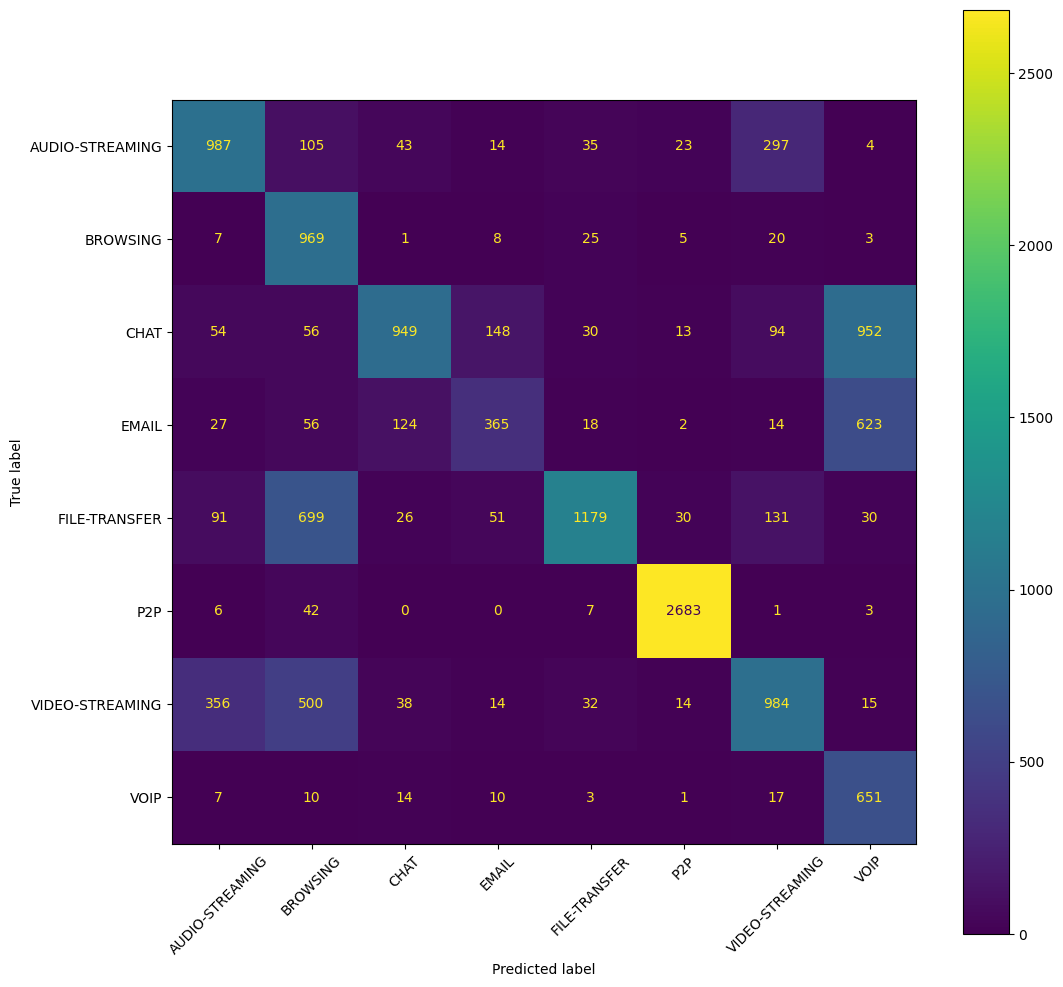

                 precision    recall  f1-score   support

AUDIO-STREAMING       0.64      0.65      0.65      1508
       BROWSING       0.40      0.93      0.56      1038
           CHAT       0.79      0.41      0.54      2296
          EMAIL       0.60      0.30      0.40      1229
  FILE-TRANSFER       0.89      0.53      0.66      2237
            P2P       0.97      0.98      0.97      2742
VIDEO-STREAMING       0.63      0.50      0.56      1953
           VOIP       0.29      0.91      0.43       713

       accuracy                           0.64     13716
      macro avg       0.65      0.65      0.60     13716
   weighted avg       0.73      0.64      0.64     13716

Sample 0: Predicted=VOIP, Confidence=0.43, Action=BLOCK
Sample 1: Predicted=FILE-TRANSFER, Confidence=0.85, Action=BLOCK
Sample 2: Predicted=BROWSING, Confidence=0.41, Action=ALLOW
Sample 3: Predicted=BROWSING, Confidence=0.54, Action=BLOCK
Sample 4: Predicted=VIDEO-STREAMING, Confidence=0.48, Action=BLOCK
Sampl

In [29]:
# ------------------------
# Main
# ------------------------
def main():
    # ------------------------
    # Φόρτωση και προεπεξεργασία dataset
    # ------------------------
    train_data, train_labelp, val_data, val_labelp, test_data, test_labelp, unique_labels = loadDataset()
    nclass = len(unique_labels)  # Αριθμός μοναδικών κλάσεων
    train_label = to_categorical(train_labelp, nclass)  # Μετατροπή ετικετών σε one-hot για εκπαίδευση
    val_label = to_categorical(val_labelp, nclass)      # Μετατροπή ετικετών validation σε one-hot

    # ------------------------
    # Υπολογισμός βαρών κλάσεων για αντιμετώπιση ανισορροπίας
    # ------------------------
    raw_weights = compute_class_weight('balanced', classes=np.unique(train_labelp), y=train_labelp)
    class_weights = {i: min(w, 10) for i, w in enumerate(raw_weights)}  # Περιορισμός βαρών σε 10 για αποφυγή υπερβολικής κλίμακας

    # ------------------------
    # Αναδιάταξη δεδομένων για sequence models (Conv1D, LSTM)
    # ------------------------
    train_seq = train_data[..., np.newaxis]  # Σχήμα: [δείγματα, χαρακτηριστικά, 1]
    val_seq = val_data[..., np.newaxis]
    test_seq = test_data[..., np.newaxis]

    # ------------------------
    # Εκπαίδευση ή φόρτωση προεκπαιδευμένων μοντέλων
    # ------------------------
    dense_model, hist_dense = get_or_train_model(
        "dense_model.h5", lambda: build_dense_model(train_data.shape[1], nclass),
        train_data, train_label, val_data, val_label, class_weights
    )
    conv_model, hist_conv = get_or_train_model(
        "conv1d_model.h5", lambda: build_conv1d_model(train_data.shape[1], nclass),
        train_seq, train_label, val_seq, val_label, class_weights
    )
    lstm_model, hist_lstm = get_or_train_model(
        "lstm_model.h5", lambda: build_lstm_model(train_data.shape[1], nclass),
        train_seq, train_label, val_seq, val_label, class_weights
    )

    # ------------------------
    # Σχεδίαση καμπυλών εκπαίδευσης αν τα μοντέλα εκπαιδεύτηκαν φρέσκα
    # ------------------------
    plot_history(hist_dense, "Dense")
    plot_history(hist_conv, "Conv1D")
    plot_history(hist_lstm, "LSTM")

    # ------------------------
    # Υπολογισμός βέλτιστων thresholds ανά κλάση χρησιμοποιώντας validation set
    # ------------------------
    print("\nΥπολογισμός βέλτιστων thresholds ανά κλάση στο validation set...")
    per_class_thresholds = compute_per_class_thresholds(
        dense_model, conv_model, lstm_model,
        val_data, val_seq, val_labelp, nclass
    )

    # ------------------------
    # Προβλέψεις ensemble στο test set
    # ------------------------
    p_avg = ensemble_predict(dense_model, conv_model, lstm_model, test_data, test_seq)
    pred_classes = p_avg.argmax(axis=1)  # Προβλεπόμενη κλάση για κάθε δείγμα

    # ------------------------
    # Αποφάσεις IPS χρησιμοποιώντας thresholds ανά κλάση
    # ------------------------
    actions = []
    for i in range(len(pred_classes)):
        cls = pred_classes[i]
        conf = p_avg[i].max()                # Μέγιστη πιθανότητα προβλέψεων
        threshold = per_class_thresholds.get(cls, 0.7)  # Threshold για συγκεκριμένη κλάση
        action = "BLOCK" if conf >= threshold else "ALLOW"
        actions.append(action)

    # ------------------------
    # Πίνακας σύγχυσης και αναφορά ταξινόμησης
    # ------------------------
    cm = confusion_matrix(test_labelp, pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    fig, ax = plt.subplots(figsize=(12,12))
    disp.plot(ax=ax, xticks_rotation=45)
    plt.show()
    print(classification_report(test_labelp, pred_classes, target_names=unique_labels))

    # ------------------------
    # Εμφάνιση των πρώτων 10 δειγμάτων με αποφάσεις IPS
    # ------------------------
    for i in range(10):
        pidx = pred_classes[i]
        conf = p_avg[i].max()
        print(f"Sample {i}: Predicted={unique_labels[pidx]}, Confidence={conf:.2f}, Action={actions[i]}")

    # ------------------------
    # Στατιστικά IPS ανά κλάση
    # ------------------------
    blocked_per_class = {label: 0 for label in unique_labels}
    allowed_per_class = {label: 0 for label in unique_labels}

    # Καταμέτρηση BLOCK και ALLOW για κάθε κλάση
    for i, (p_idx, conf) in enumerate(zip(pred_classes, p_avg.max(axis=1))):
        label_name = unique_labels[p_idx]
        threshold = per_class_thresholds[p_idx]
        if conf >= threshold:
            blocked_per_class[label_name] += 1
        else:
            allowed_per_class[label_name] += 1

    # Εκτύπωση συνοπτικών στοιχείων
    print("\n=== Συνοπτικά αποτελέσματα δράσεων IPS ανά κλάση ===")
    for label in unique_labels:
        total = blocked_per_class[label] + allowed_per_class[label]
        print(f"{label}: BLOCK={blocked_per_class[label]} / {total}, ALLOW={allowed_per_class[label]} / {total}")

# ------------------------
# Εκτέλεση main
# ------------------------
if __name__ == "__main__":
    main()
